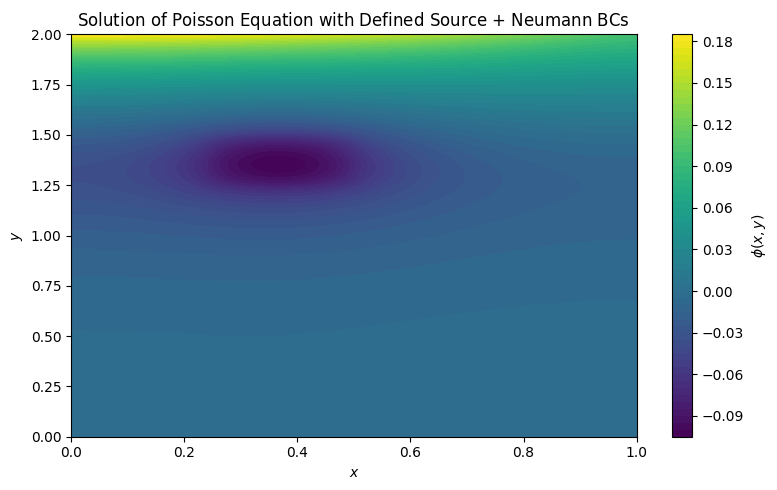

In [1]:
import numpy as np
from scipy.fft import dctn, idctn
import matplotlib.pyplot as plt

# Grid setup
dx = dy = 0.01
Lx, Ly = 1.0, 2.0
Nx, Ny = int(Lx/dx), int(Ly/dy)

x = np.linspace(0, Lx, Nx+1)
y = np.linspace(0, Ly, Ny+1)
X, Y = np.meshgrid(x, y, indexing='ij')

# ------------------------------------------------------------------------------
# Construct source density rho_source (task-defined source)
# ------------------------------------------------------------------------------
rho_source = np.zeros((Nx+1, Ny+1))

# Define source region: 0.25 <= x < 0.5 and 1.25 <= y < 1.5
x_region = (x >= 0.25) & (x < 0.5)
y_region = (y >= 1.25) & (y < 1.5)

for i in range(Nx+1):
    for j in range(Ny+1):
        if x_region[i] and y_region[j]:
            rho_source[i, j] = 4 * np.pi

# ------------------------------------------------------------------------------
# Add pseudo-source term from Neumann BC on y=2 (as additional source)
# ------------------------------------------------------------------------------
rho_bc = np.zeros_like(rho_source)
g_top = np.sqrt(1 - x**2)
rho_bc[:, -2] -= g_top / dy

# Total source rho (source + BC induced)
rho = rho_source + rho_bc

# ------------------------------------------------------------------------------
# 2D DCT-II on interior points
# ------------------------------------------------------------------------------
rho_inner = rho[1:-1, 1:-1]
rho_hat = dctn(rho_inner, type=2, norm='ortho')

# ------------------------------------------------------------------------------
# Solve Poisson equation in spectral domain
# ------------------------------------------------------------------------------
m = np.arange(1, Nx)[:, None]
n = np.arange(1, Ny)[None, :]

lambda_mn = 2 * (np.cos(np.pi * m / Nx) + np.cos(np.pi * n / Ny) - 2)

phi_hat = (dx**2) * rho_hat / lambda_mn

# ------------------------------------------------------------------------------
# Inverse DCT-II
# ------------------------------------------------------------------------------
phi_inner = idctn(phi_hat, type=2, norm='ortho')

# ------------------------------------------------------------------------------
# Embed back to full domain and enforce BCs
# ------------------------------------------------------------------------------
phi = np.zeros((Nx+1, Ny+1))
phi[1:-1, 1:-1] = phi_inner

phi[0, :]  = phi[1, :]
phi[-1, :] = phi[-2, :]
phi[:, 0]  = phi[:, 1]
phi[:, -1] = phi[:, -2] + g_top * dy

# ------------------------------------------------------------------------------
# Visualization
# ------------------------------------------------------------------------------
plt.figure(figsize=(8, 5))
levels = 60
cp = plt.contourf(X, Y, phi, levels=levels, cmap='viridis')
plt.colorbar(cp, label=r'$\phi(x,y)$')
plt.xlabel(r'$x$')
plt.ylabel(r'$y$')
plt.title(r'$\text{Solution of Poisson Equation with Defined Source + Neumann BCs}$')
plt.tight_layout()
plt.show()

Sum of h[n] (should be close to 1): 0.999999999999999


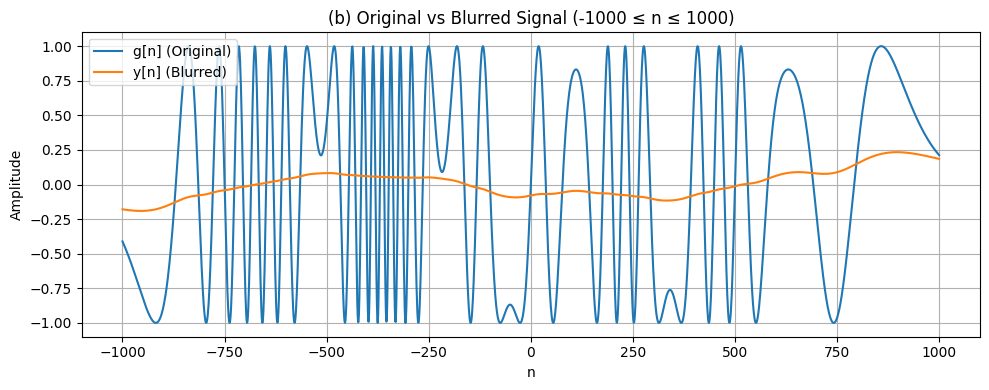

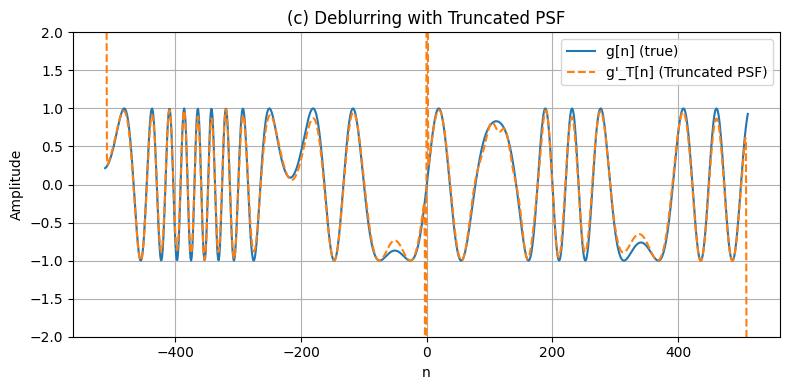

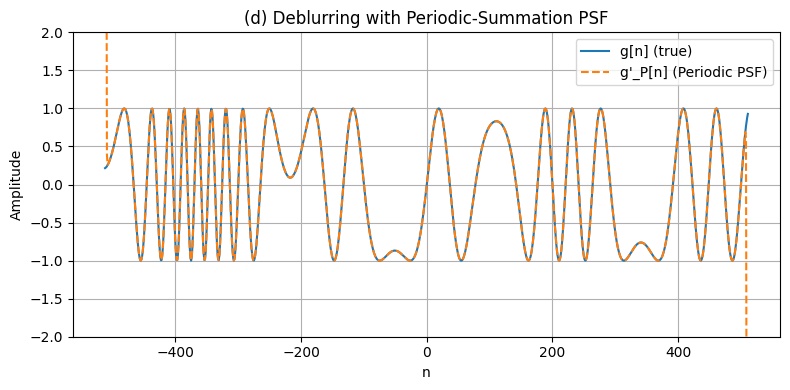

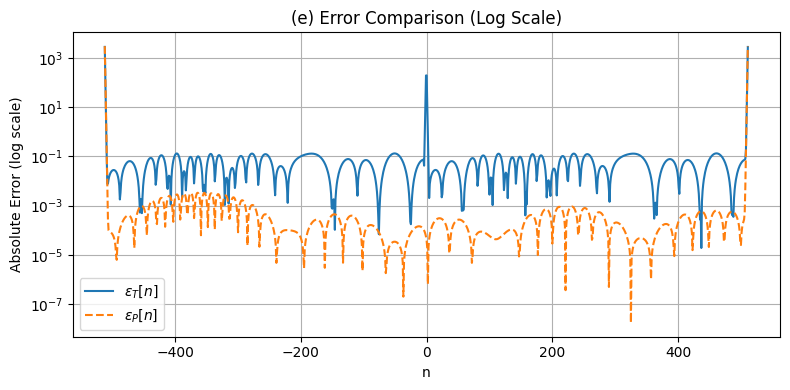

In [2]:
import numpy as np
import matplotlib.pyplot as plt

# =============================================================================
# (a) Check l1-norm of PSF h[n]
# =============================================================================
# PSF: h[n] = (1/399) * 0.995^{|n|}, for all integers n
n_full = np.arange(-10000, 10001)  # Large enough range to approximate infinite sum
h_full = (1/399) * (0.995 ** np.abs(n_full))
print("Sum of h[n] (should be close to 1):", np.sum(h_full))

# =============================================================================
# Generate full range signals: g[n], h[n], y[n]
# =============================================================================
# Generate g[n] over a large range
n_long = np.arange(-4000, 4001)  # -4000 <= n <= 4000
g_long = np.sin(
    (1 / (4 * 10**10)) *
    n_long * (n_long + 300) * (n_long + 100) * (n_long - 200) * (n_long - 500) *
    np.exp(-(n_long/300)**2)
)

# Full PSF h[n] over same range
h_long = (1/399) * (0.995 ** np.abs(n_long))

# Blurred signal y[n] via convolution
y_long = np.convolve(g_long, h_long, mode='same')

# =============================================================================
# (b) Plot g[n] and y[n] for -1000 <= n <= 1000
# =============================================================================
n_plot = np.arange(-1000, 1001)  # -1000 to 1000 (total 1001 points)

# Center of n_long is at index 4000 (corresponding to n=0)
center_idx = 4000

# Correctly slice g and y for plotting
g_plot = g_long[center_idx - 1000 : center_idx + 1001]
y_plot = y_long[center_idx - 1000 : center_idx + 1001]

plt.figure(figsize=(10, 4))
plt.plot(n_plot, g_plot, label='g[n] (Original)')
plt.plot(n_plot, y_plot, label='y[n] (Blurred)')
plt.title('(b) Original vs Blurred Signal (-1000 ≤ n ≤ 1000)')
plt.xlabel('n')
plt.ylabel('Amplitude')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# Prepare observed segment for (c)-(e)
# =============================================================================
M = 1024
n_window = np.arange(-M//2, M//2)  # n from -512 to 511

# Extract g[n] and y[n] for observed segment (-512 to 511)
idx_start = center_idx - 512
g_true = g_long[idx_start: idx_start + M]
y_obs = y_long[idx_start: idx_start + M]

# Fourier transform of observed y[n]
eps = 1e-6  # small epsilon to avoid division by zero
Y = np.fft.fft(np.fft.ifftshift(y_obs))

# =============================================================================
# (c) Deblur using Truncated PSF
# =============================================================================
# Truncate h[n] to -512 to 511
h_trunc = (1/399) * (0.995 ** np.abs(n_window))
h_trunc /= np.sum(np.abs(h_trunc))  # Normalize l1-norm to 1

# Fourier transform of truncated PSF
H_T = np.fft.fft(np.fft.ifftshift(h_trunc))

# Recover G_T by inverse filtering
G_T = Y / (H_T + eps)
g_T = np.fft.fftshift(np.fft.ifft(G_T).real)

plt.figure(figsize=(8, 4))
plt.plot(n_window, g_true, label="g[n] (true)")
plt.plot(n_window, g_T, '--', label="g'_T[n] (Truncated PSF)")
plt.title("(c) Deblurring with Truncated PSF")
plt.xlabel("n")
plt.ylabel("Amplitude")
plt.ylim([-2, 2])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# (d) Deblur using Periodic-Summation PSF
# =============================================================================
# Periodic summation of h[n]
def h_inf(idx):
    return (1/399) * (0.995 ** np.abs(idx))

h_periodic = np.zeros(M)
# Sum over a few periods because 0.995^n decays fast
for k in range(-8, 9):
    h_periodic += h_inf(n_window + k*M)
h_periodic /= np.sum(np.abs(h_periodic))  # Normalize l1-norm to 1

# Fourier transform of periodic PSF
H_P = np.fft.fft(np.fft.ifftshift(h_periodic))

# Recover G_P by inverse filtering
G_P = Y / (H_P + eps)
g_P = np.fft.fftshift(np.fft.ifft(G_P).real)

plt.figure(figsize=(8, 4))
plt.plot(n_window, g_true, label="g[n] (true)")
plt.plot(n_window, g_P, '--', label="g'_P[n] (Periodic PSF)")
plt.title("(d) Deblurring with Periodic-Summation PSF")
plt.xlabel("n")
plt.ylabel("Amplitude")
plt.ylim([-2, 2])
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# =============================================================================
# (e) Error plots in log scale
# =============================================================================
# Calculate absolute errors
eps_T = np.abs(g_T - g_true)
eps_P = np.abs(g_P - g_true)

# Prevent log(0) error
eps_T[eps_T == 0] = 1e-12
eps_P[eps_P == 0] = 1e-12

plt.figure(figsize=(8, 4))
plt.semilogy(n_window, eps_T, label=r"$\epsilon_T[n]$")
plt.semilogy(n_window, eps_P, '--', label=r"$\epsilon_P[n]$")
plt.title("(e) Error Comparison (Log Scale)")
plt.xlabel("n")
plt.ylabel("Absolute Error (log scale)")
plt.legend()
plt.grid(True, which='both')
plt.tight_layout()
plt.show()